## Test Logistic Regression (Fake vs Real news) model generalisation

## News Articles dataset
https://www.kaggle.com/datasets/ruchi798/source-based-news-classification

### Import libraries

In [36]:
import pandas as pd # data processing 
import matplotlib.pyplot as plt # plotting 
import numpy as np # linear algebra 
import seaborn as sns 

# tool to read data csv file (it is faster than pandas and can read files from .zip)
import datatable as dt

# import kaggle

# colored output text
from termcolor import colored

import re
import string 

from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS

# module implements binary protocols for serializing and de-serializing a Python object
import pickle

# natural language toolkit (https://realpython.com/nltk-nlp-python/)
# (https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/)
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# filter common words
from nltk.corpus import stopwords
# split text into words
from nltk.tokenize import word_tokenize
# nltk.download('averaged_perceptron_tagger')

# reduce words to their root by transformin to initial form with ectual meaning (ex. goes -> go )
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('omw-1.4')

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

from sklearn.metrics import plot_roc_curve

# Silent warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Search for datasets

In [2]:
# search for the dataset
# !kaggle datasets list -s 'fake-news'

### Dowload datasets

In [3]:
# # https://www.kaggle.com/datasets/ruchi798/source-based-news-classification
# !kaggle datasets download -d ruchi798/source-based-news-classification

In [4]:
# !mv source-based-news-classification.zip data

### Read dataset

In [5]:
raw_df = dt.fread('data/source-based-news-classification.zip/news_articles.csv', header=True).to_pandas()
raw_df.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,True
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,True
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,True
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,True
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,True


### Drop redundant features

In [6]:
df = raw_df[['text', 'label']].copy()
df.head()

,text,label
0,print they should pay all the back all the mon...,Real
1,why did attorney general loretta lynch plead t...,Real
2,red state \nfox news sunday reported this mor...,Real
3,email kayla mueller was a prisoner and torture...,Real
4,email healthcare reform to make america great ...,Real


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2096 non-null   object
 1   label   2096 non-null   object
dtypes: object(2)
memory usage: 32.9+ KB


In [8]:
df.groupby('label').count()

,text
label,
,1
Fake,1294
Real,801


In [9]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
df[df['label']== '']

,text,label
2095,,


In [11]:
df['label'].replace({'Real': 1, 'Fake': 0}, inplace=True)
df.head()

,text,label
0,print they should pay all the back all the mon...,1
1,why did attorney general loretta lynch plead t...,1
2,red state \nfox news sunday reported this mor...,1
3,email kayla mueller was a prisoner and torture...,1
4,email healthcare reform to make america great ...,1


### Plot label count

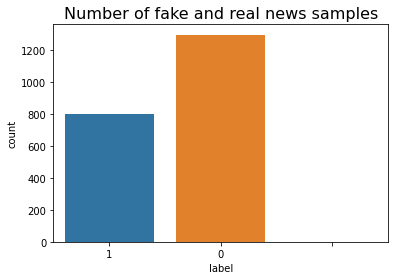

In [12]:
sns.countplot(x='label', data=df)
plt.title('Number of fake and real news samples', fontdict={'fontsize':16})
plt.show()

### Create function to clean data

In [13]:
def remove_duplicates(df):
    shape_before = df.shape
    # check if there are duplicates
    duplicate = df['text'][df['text'].duplicated()].index
    text = f"Found {len(duplicate)} duplicate in {df.shape[0]} samples"
    print(colored(text, 'blue', attrs=['bold']))
    # remove duplicates
    df.drop(index=duplicate, inplace=True)
    text = f"Data shape before {shape_before}, after {df.shape}"
    print(colored(text, 'green', attrs=['bold']))
    return df


def remove_Reuters(df):
    shape_before = df.shape
    pattern = r'[A-Z]* ?\(Reuters\)'
    
    # check if <CITY> (Reuters) in text
    test_df = df['text'].copy().to_frame()
    test_df['patterns'] = test_df['text'].map(lambda x: len(re.findall(pattern, x)))
    if any(test_df['patterns'] > 0):
        text = f"{test_df.groupby('patterns')['text'].count()[1]} of {test_df.shape[0]} samples have <City> (REUTERS) pattern."
        print(colored(result, 'blue', attrs=['bold'])) 
        # remove
        df['text'] = df['text'].map(lambda x: re.sub(pattern, '', x))
        text = f"Data shape before {shape_before}, after {df.shape}"
        print(colored(text, 'green', attrs=['bold']))
    return df


def remove_links(df):
    pattern = r'https?://[^\n ]*'

    # find how many samples have links in text
    test_df = df['text'].copy().to_frame()
    test_df['patterns'] = test_df['text'].map(lambda x: len(re.findall(pattern, x)))
    if any(test_df['patterns'] > 0):
        text = f"{test_df.groupby('patterns')['text'].count()[1]} of {df.shape[0]} samples have link"
        print(colored(text, 'blue', attrs=['bold']))

        df['text'] = df['text'].map(lambda x: re.sub(pattern, '', x))
    return df


def remove_tags(text):  
    # parse html content
    soup = BeautifulSoup(text, "html.parser")
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)


def remove_empty_text(df):
    shape_before = df.shape
    
    text = f"Found {df[df['text'].str.strip()==''].count()[1]} empty values of text"
    print(colored(text, 'blue', attrs=['bold']))
    
    df = df[df['text'].str.strip()!='']
    text = f"Data shape before {shape_before}, after {df.shape}"
    print(colored(text, 'green', attrs=['bold']))
    return df

def remove_empty_label(df):
    shape_before = df.shape
    
    text = f"Found {df[df['label']==''].count()[1]} empty values of label"
    print(colored(text, 'blue', attrs=['bold']))
    
    df = df[df['label']!='']
    text = f"Data shape before {shape_before}, after {df.shape}"
    print(colored(text, 'green', attrs=['bold']))
    return df


def clean_df(df):
    # remove duplicates
    df = remove_duplicates(df)
    
    # remove source in form of <CITY> (Reuters) if any 
    df = remove_Reuters(df)
    
    # remove links (http/https) 
    df = remove_links(df)      
    
    # remove HTML
    df['text'] = df['text'].map(lambda x: remove_tags(x))
    
    # remove empty text values
    df = remove_empty_text(df)
    
    # remove empty label values
    df = remove_empty_label(df)    
    return df    

In [14]:
df = clean_df(df)
df.head()

Found 154 duplicate in 2096 samples
Data shape before (2096, 2), after (1942, 2)
Found 1 empty values of text
Data shape before (1942, 2), after (1941, 2)
Found 0 empty values of label
Data shape before (1941, 2), after (1941, 2)


,text,label
0,print they should pay all the back all the mon...,1
1,why did attorney general loretta lynch plead t...,1
2,red state \nfox news sunday reported this mor...,1
3,email kayla mueller was a prisoner and torture...,1
4,email healthcare reform to make america great ...,1


### Wordcloud plot

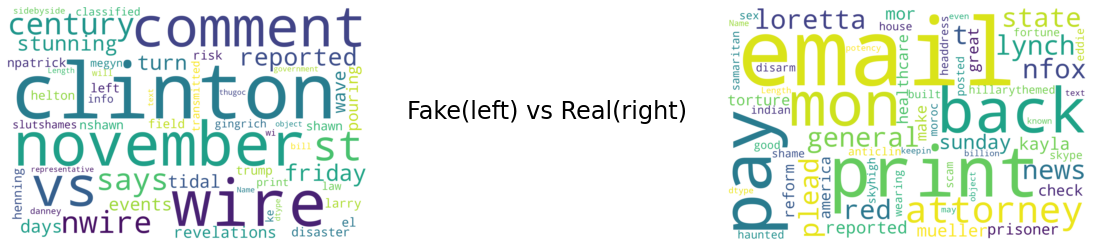

In [15]:
fake_ = df.text[df['label']==0]
real_ = df.text[df['label']==1]

def plot_fake_vs_real(fake, real):
    wordcloud_fake = WordCloud(width = 2000, height = 1300,
                              background_color = 'white', 
                              stopwords = STOPWORDS).generate(str(fake))
    wordcloud_real = WordCloud(width = 2000, height = 1300,
                              background_color = 'white', 
                              stopwords = STOPWORDS).generate(str(real))
    
    # plot WordCloud img 
    plt.subplots(figsize=(15,6))
    
    plt.subplot(1,3,1)
    plt.imshow(wordcloud_fake, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    
    plt.suptitle("Fake(left) vs Real(right)", y=0.5, va='center', size = 24)
    
    plt.subplot(1,3,3)
    plt.imshow(wordcloud_real, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

    
plot_fake_vs_real(fake_, real_)
plt.show()      

### Save cleaned dataset

In [16]:
cleaned_df = df[['text', 'label']].copy()
cleaned_df.to_csv('data/cleaned_alternative_data.csv', index=False, encoding='utf-8')

### Load cleaned dataset

In [17]:
test_df = pd.read_csv('data/cleaned_alternative_data.csv')
test_df.head()

,text,label
0,print they should pay all the back all the mon...,1
1,why did attorney general loretta lynch plead t...,1
2,red state \nfox news sunday reported this mor...,1
3,email kayla mueller was a prisoner and torture...,1
4,email healthcare reform to make america great ...,1


### Preprocess (remove stopwords, tag, lemmatize) 

In [18]:
# simplifies position of speech tags

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
 
    # tokenize text into words, clean of punctuation and stopwords
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]  

    # tokenize text including position of speech
    text = nltk.pos_tag(text)   
    text = list(map(lambda x: (x[0], pos_tagger(x[1])), text))

    # lemmatize words with respect to position of speech
    text_ = []    
    for word, tag in text:
        if tag is None:
            text_.append(word)
        else:
            text_.append(lemma.lemmatize(word, tag))
    text = ' '.join(text_) 
    return text

In [19]:
test_df['text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,text,label
0,print pay back money plus interest entire fami...,1
1,attorney general loretta lynch plead fifth bar...,1
2,red state fox news sunday report morning antho...,1
3,email kayla mueller prisoner torture isi chanc...,1
4,email healthcare reform make america great sin...,1


### Separate dependent variable

In [20]:
X = test_df['text'].values
y = test_df['label'].values

X.shape, y.shape

((1941,), (1941,))

### Vectorize data

In [21]:
# load vectorizer from pickle file (previously fitted on train data)
with open('Log_Reg/tfidfVectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

X2 = X.copy()    
# transform data
X = vectorizer.transform(X)

## Logistic Regression generalization test

### Load trained algorithm

In [22]:
with open('Log_Reg/LogReg_tuned.pkl', 'rb') as file:
    log_reg = pickle.load(file)

### Print classification report 

In [23]:
print(classification_report(y, log_reg.predict(X), target_names = ['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.65      0.86      0.74      1208
        Real       0.50      0.23      0.31       733

    accuracy                           0.62      1941
   macro avg       0.58      0.55      0.53      1941
weighted avg       0.59      0.62      0.58      1941



### Plot confusion matrix

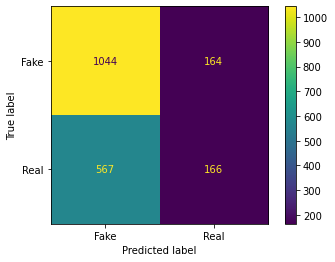

In [24]:
plot_confusion_matrix(log_reg, X, y, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### Plot Receiver operating characteristic (ROC) curve

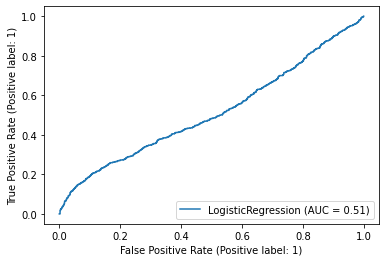

In [25]:
metrics.plot_roc_curve(log_reg, X, y) 
plt.show()

## XGBoost generalization test

### Load trained algorithm

In [26]:
with open('xgboost/XGBoost_tuned.pkl', 'rb') as file:
    xgb = pickle.load(file)

### Print classification report 

In [27]:
print(classification_report(y, xgb.predict(X), target_names = ['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.65      0.88      0.75      1208
        Real       0.52      0.21      0.30       733

    accuracy                           0.63      1941
   macro avg       0.58      0.55      0.52      1941
weighted avg       0.60      0.63      0.58      1941



### Plot confusion matrix

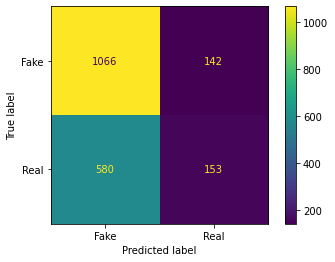

In [28]:
plot_confusion_matrix(xgb, X, y, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### Plot Receiver operating characteristic (ROC) curve

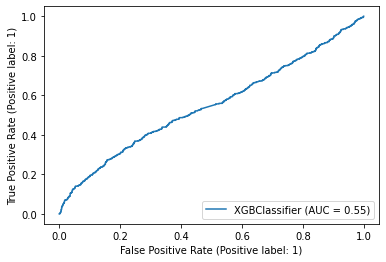

In [29]:
metrics.plot_roc_curve(xgb, X, y) 
plt.show()

## Naive Bayes test

### Load trained algorithm

In [30]:
with open('naive_bayes.pkl', 'rb') as file:
    nb = pickle.load(file)
    
# load vectorizer from pickle file (previously fitted on train data)
with open('countfVectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# transform data
X2 = vectorizer.transform(X2)

### Print classification report 

In [31]:
print(classification_report(y, nb.predict(X2), target_names = ['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.64      0.82      0.72      1208
        Real       0.46      0.25      0.32       733

    accuracy                           0.61      1941
   macro avg       0.55      0.54      0.52      1941
weighted avg       0.57      0.61      0.57      1941



### Plot confusion matrix

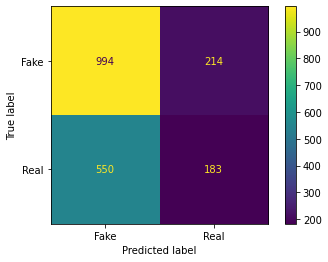

In [32]:
plot_confusion_matrix(nb, X2, y, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### Plot Receiver operating characteristic (ROC) curve

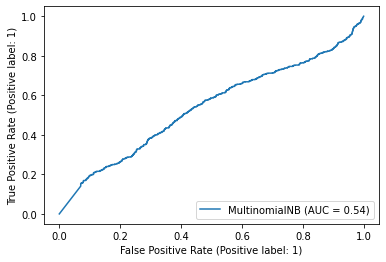

In [33]:
metrics.plot_roc_curve(nb, X2, y) 
plt.show()

### Comparison ROC plot

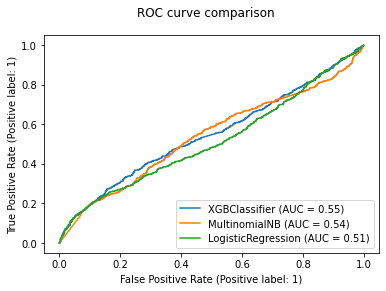

In [39]:
xgb_disp = plot_roc_curve(xgb, X, y)
nb_disp = plot_roc_curve(nb, X2, y, ax=xgb_disp.ax_)
logreg_disp = plot_roc_curve(log_reg, X, y, ax=xgb_disp.ax_)
logreg_disp.figure_.suptitle("ROC curve comparison")

plt.show()